# Validación

Hasta el momento hemos logrado entrenar la red, es decir, encontrar los pesos tal que se reduce el error entre la salida de la red y la salida esperada. Con los pesos entrenados, la red pude predecir la clase que corresponde a una entrada que no ha visto. Este proceso de predicción conocido como inferencia es la parte más interesante de las redes ya que permite generalizar su uso a casos no vistos. Sin embargo, durante el entrenamiento se puede suscitar un fenómeno conocido como sobre-ajuste (overfitting), donde la red reduce de manera adecuada la pérdida con respecto a los datos de entrenamiento, pero al momento de encontrarse con ejemplos desconocidos, ésta tiene un rendimiento pobre. Este efecto es contrario, por que buscamos **generalizar** el rendimiento de tal forma que clasifique bien ejemplos que no han sido vistos. 

Para saber que tan bien está generalizando la red se realiza un proceso de validación. En este proceso de validación se verifican las predicciones de la red en un conjunto de datos de validación (En la literatura a este conjunto también se le denomina de prueba).

En el resto del notebook veremos como realizar la validación de la red durante el entrenamiento.

También haremos uso del *dropout*

In [1]:
# Cargamos paquetes necesarios

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

#helper was developed by Udacity under MIT license
import helper

## Conjunto de datos (Dataset)

Para este ejemplo utilizaremos el Fashion MNIST. Este dataset esta constituido por imágenes de 28 x 28 pixeles y cada imagen contiene prendas como ropa o zapatos.  

In [2]:
# Definimos una transformación de los datos
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Descargamos el conjunto de entrenamiento y cargamos mediante un dataLoader
trainset = datasets.FashionMNIST('Fashion/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Descargamos el conjunto de validación
testset = datasets.FashionMNIST('Fashion/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

#TODO: Know your data
dataset_sizes = {x: len(x) for x in [trainset, testset]}

print ("Dataset Size: "+ str(dataset_sizes) + "\n")


Dataset Size: {Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: Fashion/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None: 60000, Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: Fashion/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None: 10000}



## Red Neuronal

En esta ocasión, construiremos la red de forma más general, donde las capas ocultas se generarán a partir de un vector que indica el número de capas y el número de nodos de cada capa. Haremos uso del módulo *nn.ModuleList* que nos permitirá crear un número arbitrario de capas. En cierta forma *nn.ModuleList* se comporta como una lista simple de python. 

In [3]:
class RedNeuronal(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p = 0.5):
        '''
        Construye una red de tamaño arbitrario.
        
        Parámetros:
        input_size: cantidad de elementos en la entrada
        output_size: cantidada de elementos en la salida 
        hidden_layers: cantidad de elementos por cada capa oculta
        drop_p: probabilidad de "tirar" (drop) una neurona [0,1] 
        '''
        # llamamos al constructor de la superclase
        super().__init__()
        
        # Agregamos la primera capa
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # agregamos cada una de las capas, zip empareja el número de entradas con las salidas
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        # agregamos la capa de salida final de la red
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        # Incluimos drop-out en la red
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Pase hacia adelante en la red, el regreso son las probabilidades en el dominio log '''
        
        # Hacemos un pase frontal en cada una de las capas ocultas, 
        # La funció de activación es un RELU combinado con dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

## Entrenamiento

La pérdida (loss) nos indica que tan bien o mal está clasificando nuestra red. Dado que estamos utilizando el dominio log para calcular las salidas de la red, utilizaremos el criterio negative log loss *nn.NLLLoss()*. Como optimizador utilzaremos ADAM optimzer, el cual combina el gradiente descendiente estocástico con el momentum. 

In [4]:
# Create the network, define the criterion and optimizer
model = RedNeuronal(784, 10, [800, 400], drop_p=0.45)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

Ahora programaremos la validación. En esta etapa se mide la exactitud de la red en el conjunto de prueba a fin de ver que tan bien está generalizando la red. Como estamos utilizando drop out durante el entrenamiento al momento de hacer una inferencia este proceso se debe desactivar. Afortunadamente pytorch provee dos modos de funcionamiento para la red: entrenamiento o evaluación, model.train() y model.eval() respectivamente.  

In [5]:
# Implementamos una función de evaluación
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        images.resize_(images.shape[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

### Implementación del entrenamiento y validación



In [6]:
#hiperparámetro
epochs = 5
steps = 0
running_loss = 0
print_every = 100
for e in range(epochs):
    # Cambiamos a modo entrenamiento
    model.train()
    for images, labels in trainloader:
        steps += 1
        
        # Aplanar imágenes a un vector de 784 elementos
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        # Backprogamation
        loss.backward()
        # Optimización
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Cambiamos a modo de evaluación
            model.eval()
            
            # Apagamos los gradientes, reduce memoria y cálculos
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure training is back on
            model.train()

Epoch: 1/5..  Training Loss: 0.868..  Test Loss: 0.655..  Test Accuracy: 0.749
Epoch: 1/5..  Training Loss: 0.654..  Test Loss: 0.571..  Test Accuracy: 0.787
Epoch: 1/5..  Training Loss: 0.617..  Test Loss: 0.554..  Test Accuracy: 0.794
Epoch: 1/5..  Training Loss: 0.621..  Test Loss: 0.526..  Test Accuracy: 0.812
Epoch: 1/5..  Training Loss: 0.596..  Test Loss: 0.535..  Test Accuracy: 0.800
Epoch: 1/5..  Training Loss: 0.597..  Test Loss: 0.527..  Test Accuracy: 0.810
Epoch: 1/5..  Training Loss: 0.577..  Test Loss: 0.517..  Test Accuracy: 0.818
Epoch: 1/5..  Training Loss: 0.574..  Test Loss: 0.479..  Test Accuracy: 0.826
Epoch: 1/5..  Training Loss: 0.582..  Test Loss: 0.488..  Test Accuracy: 0.826
Epoch: 2/5..  Training Loss: 0.521..  Test Loss: 0.480..  Test Accuracy: 0.822
Epoch: 2/5..  Training Loss: 0.550..  Test Loss: 0.488..  Test Accuracy: 0.830
Epoch: 2/5..  Training Loss: 0.552..  Test Loss: 0.466..  Test Accuracy: 0.831
Epoch: 2/5..  Training Loss: 0.542..  Test Loss: 0.4

## Inferencia

Ahora que ya hemos entrenado la red vamos a probar cual es su rendimiento en la clasificación de las prendas de vestir. 

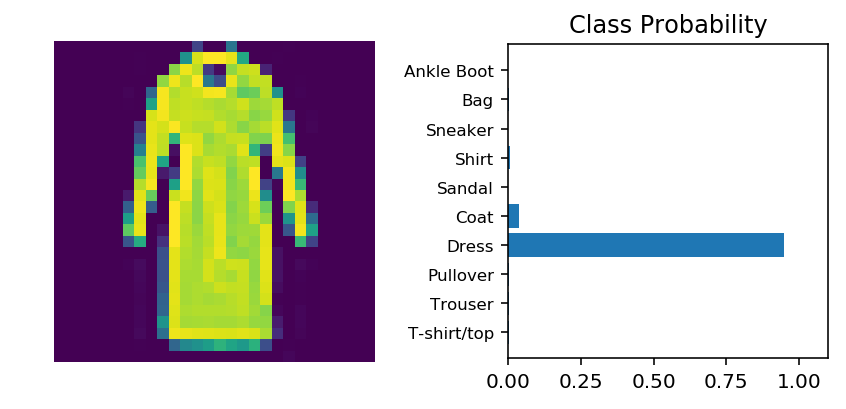

In [9]:
# Probemos la red!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Aplanamos la imagenes
img = img.view(1, 784)

# Estimamos para cada imagen la probabilidad de pertenencia a una clase (softmax)
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Graficamos
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')